In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

import pandas as pd

In [4]:


# Lee el archivo CSV en un DataFrame de Pandas
data = pd.read_csv("/content/drive/MyDrive/datasets/chineseMNIST.csv")

# Muestra las primeras filas del DataFrame
# print(data.head())
data.info()

# La primera columna es la etiqueta (dígito) y las columnas restantes son valores de píxeles
y = data.iloc[:, 1]  # Extrae las etiquetas
X = data.iloc[:, :-2]  # Extrae los valores de píxeles desde la segunda columna hasta el final

# Muestra las dimensiones de X y y
print(X.shape)
print(y.shape)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Columns: 4098 entries, pixel_0 to character
dtypes: int64(4097), object(1)
memory usage: 469.0+ MB
(15000, 4096)
(15000,)


In [8]:
# Tamaño de la capa de entrada (número de características en cada imagen)
input_layer_size = 4096

# Número de etiquetas (clases) posibles en el problema
num_labels = 10

# Tamaño del conjunto de entrenamiento (número de ejemplos)
m = y.size
print (m)



15000


In [9]:
y = y.values
X = X.values

In [10]:
# esta función proporciona una visualización rápida de datos bidimensionales
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

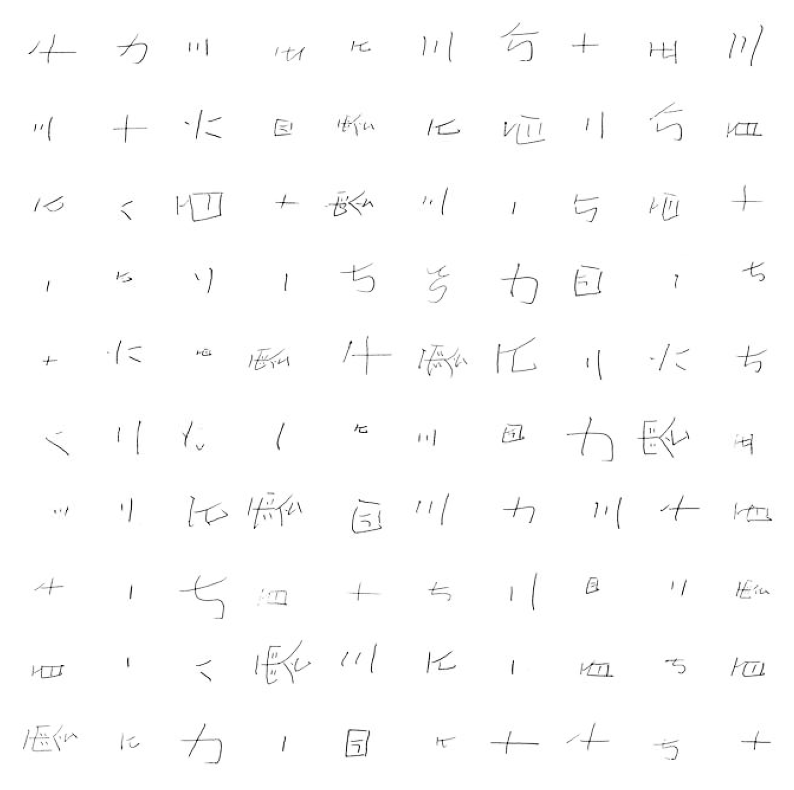

In [12]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar en pantalla
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [18]:
# transforma la entrada en un vaor entre 0 y 1
def sigmoid(z):
    # Evita valores extremos para evitar desbordamiento o underflow
    clipped_z = np.clip(z, -700, 700)

    # Aplica la función sigmoide
    return 1.0 / (1.0 + np.exp(-clipped_z))

In [19]:
def lrCostFunction(theta, X, y, lambda_):

    # Inicializa algunos valores útiles
    m = y.size

    # Convierte las etiquetas a valores enteros si son booleanas
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    # Calcula la hipótesis utilizando la función sigmoide
    h = sigmoid(X.dot(theta.T))

    # Copia los parámetros theta en una variable temporal y establece el primer elemento en 0
    temp = theta
    temp[0] = 0

    #epsilon para evitar log(0)
    #epsilon = 1e-15
    #j = (1 / m) * np.sum(-y.dot(np.log(h + epsilon)) - (1 - y).dot(np.log(1 - h + epsilon))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    # Calcula la función de costo regularizada
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    # Calcula el gradiente de la función de costo
    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad


In [21]:
def oneVsAll(X, y, num_labels, lambda_):

    # Algunas variables útiles
    m, n = X.shape  # Obtén el tamaño de la matriz de características

    all_theta = np.zeros((num_labels, n + 1))  # Inicializa la matriz de parámetros

    # Agrega unos a la matriz X (para el término de sesgo)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # Entrena un clasificador para cada clase utilizando la optimización de CG
    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)  # Inicializa los parámetros del clasificador

        options = {'maxiter': 50}  # Opciones para el método de optimización

        # Utiliza optimize.minimize para entrenar el clasificador
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c] = res.x  # Almacena los parámetros del clasificador entrenado en la matriz

    return all_theta


In [22]:
lambda_ = 0.001
all_theta = oneVsAll(X, y, num_labels, lambda_)

<ipython-input-19-ea9810bcbd34>:25: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
<ipython-input-19-ea9810bcbd34>:25: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))


In [23]:
print(all_theta.shape)
print(all_theta[0])

(10, 4097)
[3.15922054e-03 0.00000000e+00 0.00000000e+00 ... 3.79106464e-06
 4.42290875e-06 4.21229405e-06]


In [24]:
def predictOneVsAll(all_theta, X):

    m = X.shape[0]  # Número de ejemplos de prueba
    num_labels = all_theta.shape[0]  # Número de clases

    p = np.zeros(m)  # Inicializa un vector de etiquetas predichas

    # Agrega unos a la matriz X (para el término de sesgo)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # Calcula las probabilidades de pertenencia a cada clase para cada ejemplo
    # y predice la clase con la probabilidad máxima
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis=1)

    return p  # Devuelve el vector de etiquetas predichas


(15000, 4096)
Precision del conjunto de entrenamiento: 100.00%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


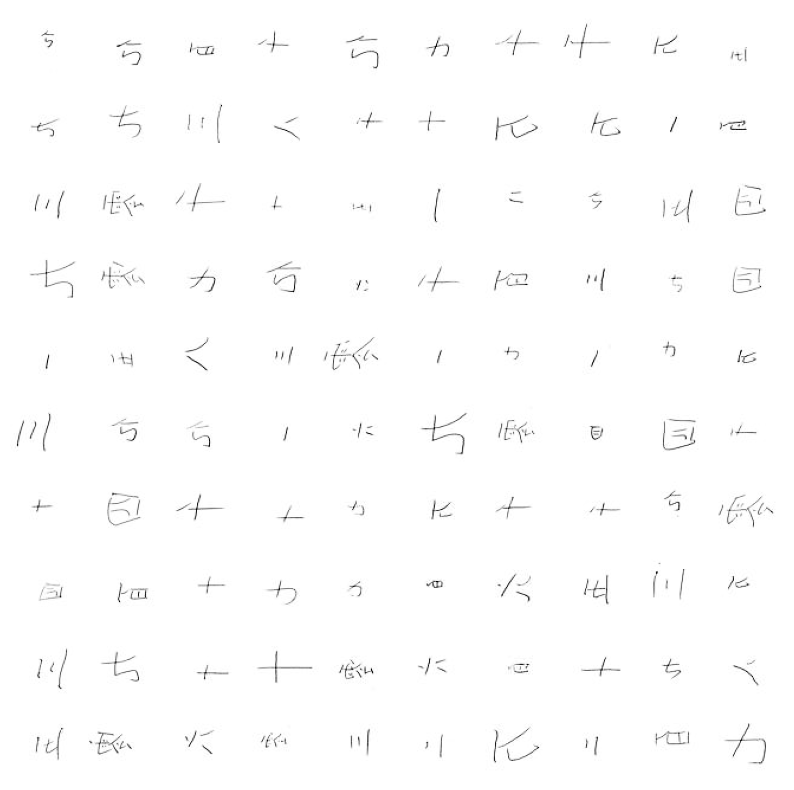

In [28]:
# Imprime las dimensiones de la matriz de características X
print(X.shape)

# Realiza predicciones utilizando la función predictOneVsAll y el conjunto de entrenamiento X
pred = predictOneVsAll(all_theta, X)

# Calcula y muestra la precisión del conjunto de entrenamiento
print('Precision del conjunto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))

# Selecciona aleatoriamente 25 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
XPrueba = X[rand_indices, :]
XPruebaV = XPrueba.copy()

# Agrega unos a la matriz de características XPrueba
XPrueba = np.concatenate([np.ones((100, 1)), XPrueba], axis=1)

# Realiza predicciones en el conjunto de prueba y almacena las etiquetas predichas en p
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis=1)

# Imprime las etiquetas predichas y las etiquetas reales correspondientes
print(p, y[rand_indices])

# Muestra los datos de prueba utilizando la función displayData
displayData(XPruebaV)